In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn import svm
from sklearn import linear_model

from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

%matplotlib inline

In [2]:
arousal = pd.read_csv("../data/annotations/arousal_cont_average.csv", index_col = 0)
valence = pd.read_csv("../data/annotations/valence_cont_average.csv", index_col = 0)

arousal = arousal.iloc[:,:-1] # We don't take the last timestamp, because some songs are slightly shorter
valence = valence.iloc[:,:-1]

annotations = pd.read_csv("../data/annotations/songs_info_ttv.csv", index_col = 0)

train_ids = annotations.index[annotations["ttv"] == "train"]
valid_ids = annotations.index[annotations["ttv"] == "validation"]
test_ids = annotations.index[annotations["ttv"] == "evaluation"]

print(f"{len(train_ids)} train cases | {len(valid_ids)} validation cases | {len(test_ids)} test cases")

495 train cases | 124 validation cases | 125 test cases


In [3]:
STEP = 0.05

def load_X(ids):
    X_raw = []

    for i in ids:
        df = pd.read_csv(f"../data/paa_features/{i}.csv")
        df = df.iloc[int(14.5 / STEP) + 1:int(44.5 / STEP) + 1,:-2] # Our desired timerange + ommiting timestamps and song IDs
        X = df.to_numpy()

        frames_per_X = int(len(X) * STEP / 0.5) # 0.5 is our frequency of y
        X_stack = np.stack(np.split(X, frames_per_X))
        X = np.concatenate([X_stack.mean(axis = 1), X_stack.std(axis = 1)], axis = 1)

        assert X.shape == (60, 136)

        X_raw.append(X)

    X_raw = np.concatenate(X_raw)
    return X_raw

In [4]:
raw_Xs = [load_X(ids) for ids in (train_ids, valid_ids, test_ids)]

scaler = StandardScaler()
scaler.fit(raw_Xs[0])
Xs = [scaler.transform(x) for x in raw_Xs]
train_X, valid_X, test_X = Xs

In [5]:
valid_X.mean(axis = 0)[:10], valid_X.std(axis = 0)[:10]

(array([-0.05337892,  0.03192162,  0.04474935, -0.01053368,  0.02933365,
        -0.03248675, -0.04216569, -0.07072368, -0.05151727,  0.06142134]),
 array([0.80542875, 1.28708618, 0.99333803, 0.92060815, 0.94351469,
        0.90340526, 0.83721521, 0.82468774, 0.94964667, 1.010049  ]))

In [6]:
train_a, valid_a, test_a = [arousal.loc[ids].to_numpy().flatten() for ids in (train_ids, valid_ids, test_ids)]
train_v, valid_v, test_v = [valence.loc[ids].to_numpy().flatten() for ids in (train_ids, valid_ids, test_ids)]

print(valid_X.shape, valid_a.shape, valid_v.shape)

(7440, 136) (7440,) (7440,)


# RBF or polynomial (3rd-degree) kernel?

--> **RBF** gives significantly better results

## Arousal

In [32]:
for kernel in ["poly", "rbf"]:
    svr = svm.SVR(kernel = kernel, cache_size = 4000)
    svr.fit(train_X, train_a)
    
    valid_predict = svr.predict(valid_X)
    valid_rmse =  sqrt(mean_squared_error(valid_a, valid_predict))
    valid_r2 = r2_score(valid_a, valid_predict)
    
    print(f"Kernel: {kernel} | RMSE: {valid_rmse} | R2: {valid_r2}")

Kernel: poly | RMSE: 0.2992580125575085 | R2: 0.06521832181840959
Kernel: rbf | RMSE: 0.22199035062605352 | R2: 0.4856167582098605


## Valence

In [33]:
for kernel in ["poly", "rbf"]:
    svr = svm.SVR(kernel = kernel, cache_size = 4000)
    svr.fit(train_X, train_v)
    
    valid_predict = svr.predict(valid_X)
    valid_rmse =  sqrt(mean_squared_error(valid_v, valid_predict))
    valid_r2 = r2_score(valid_v, valid_predict)
    
    print(f"Kernel: {kernel} | RMSE: {valid_rmse} | R2: {valid_r2}")

Kernel: poly | RMSE: 0.26997206797340806 | R2: -0.17993055163598948
Kernel: rbf | RMSE: 0.2214288612781202 | R2: 0.20624361243612677


# Regularization strength

## Arousal

In [14]:
for C in [0.1, 0.25, 0.5, 2.0]: # Results for C = 1.0 are in the previous section
    svr = svm.SVR(kernel = "rbf", C = C, cache_size = 4000)
    svr.fit(train_X, train_a)
    
    valid_predict = svr.predict(valid_X)
    valid_rmse =  sqrt(mean_squared_error(valid_a, valid_predict))
    valid_r2 = r2_score(valid_a, valid_predict)
    
    print(f"C: {C} | RMSE: {valid_rmse} | R2: {valid_r2}")

C: 0.1 | RMSE: 0.2143603828547858 | R2: 0.5203685363276205
C: 0.25 | RMSE: 0.21700932079695695 | R2: 0.5084412940554655
C: 0.5 | RMSE: 0.21909689495480725 | R2: 0.4989384674355797
C: 2.0 | RMSE: 0.22539633434154316 | R2: 0.46971137127993223


## Valence

In [15]:
for C in [0.1, 0.25, 0.5, 2.0]:
    svr = svm.SVR(kernel = "rbf", C = C, cache_size = 4000)
    svr.fit(train_X, train_v)
    
    valid_predict = svr.predict(valid_X)
    valid_rmse =  sqrt(mean_squared_error(valid_v, valid_predict))
    valid_r2 = r2_score(valid_v, valid_predict)
    
    print(f"C: {C} | RMSE: {valid_rmse} | R2: {valid_r2}")

C: 0.1 | RMSE: 0.2090509289282376 | R2: 0.2925056380476887
C: 0.25 | RMSE: 0.2125330737094453 | R2: 0.26873998639763463
C: 0.5 | RMSE: 0.21674191168161233 | R2: 0.23949061284514528
C: 2.0 | RMSE: 0.22558715886544123 | R2: 0.17615117032101213


# Final SVR training & evaluation

Best results on validation set achieved with RBF kernel and C = 0.1

In [37]:
def evaluate_model(model, X, y, name = ""):
    predict = model.predict(X)
    rmse = sqrt(mean_squared_error(y, predict))
    r2 = r2_score(y, predict)
    
    if name:
        print(f"{name} | RMSE {rmse} | R2 {r2}")
        
    return predict

## Arousal

In [19]:
final_svr_a = svm.SVR(kernel = "rbf", C = 0.1, cache_size = 4000)
final_svr_a.fit(train_X, train_a)

NameError: name 'sqsqrt' is not defined

In [38]:
train_pred_a = evaluate_model(final_svr_a, train_X, train_a, "Arousal train")
valid_pred_a = evaluate_model(final_svr_a, valid_X, valid_a, "Arousal validation")
test_pred_a = evaluate_model(final_svr_a, test_X, test_a, "Arousal test")

Arousal train | RMSE 0.1558566435306106 | R2 0.719298157601806
Arousal validation | RMSE 0.2143603828547858 | R2 0.5203685363276205
Arousal test | RMSE 0.22109588102513184 | R2 0.4009669618396784


Text(0.5, 1.0, 'Test')

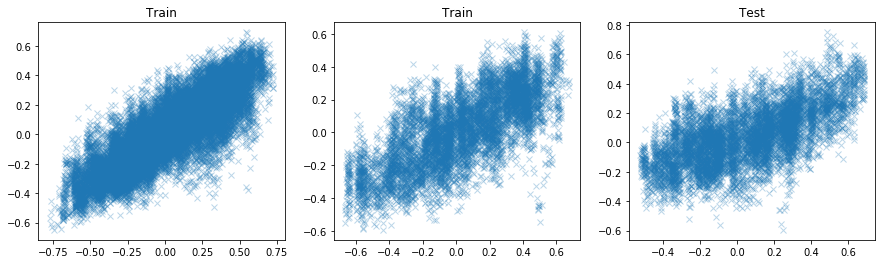

In [39]:
plt.figure(figsize=(15,4))
plt.subplot(1, 3, 1)
plt.plot(train_a, train_pred_a, "x", alpha = 0.3)
plt.title("Train")
plt.subplot(1, 3, 2)
plt.plot(valid_a, valid_pred_a, "x", alpha = 0.3)
plt.title("Train")
plt.subplot(1, 3, 3)
plt.plot(test_a, test_pred_a, "x", alpha = 0.3)
plt.title("Test")

## Valence

In [26]:
final_svr_v = svm.SVR(kernel = "rbf", C = 0.1, cache_size = 4000)
final_svr_v.fit(train_X, train_v)

SVR(C=0.1, cache_size=4000)

In [46]:
train_pred_v = evaluate_model(final_svr_v, train_X, train_v, "Valence train")
valid_pred_v = evaluate_model(final_svr_v, valid_X, valid_v, "Valence validation")
test_pred_v = evaluate_model(final_svr_v, test_X, test_v, "Valence test")

Valence train | RMSE 0.1632495250233285 | R2 0.5588209757758908
Valence validation | RMSE 0.2090509289282376 | R2 0.2925056380476887
Valence test | RMSE 0.21534418053114548 | R2 0.1218659255041018


Text(0.5, 1.0, 'Test')

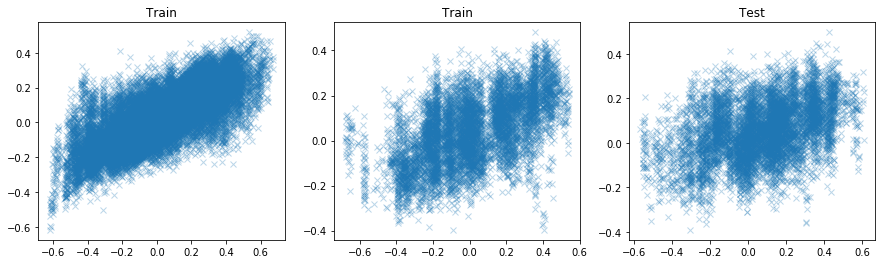

In [41]:
plt.figure(figsize=(15,4))
plt.subplot(1, 3, 1)
plt.plot(train_v, train_pred_v, "x", alpha = 0.3)
plt.title("Train")
plt.subplot(1, 3, 2)
plt.plot(valid_v, valid_pred_v, "x", alpha = 0.3)
plt.title("Train")
plt.subplot(1, 3, 3)
plt.plot(test_v, test_pred_v, "x", alpha = 0.3)
plt.title("Test")

In [45]:
import pickle

with open("../models/svr_a.pkl", "wb") as file:
    pickle.dump(final_svr_a, file)
    
with open("../models/svr_v.pkl", "wb") as file:
    pickle.dump(final_svr_v, file)